In this lab, we'll practice basic emootion recognition models using deep learning and discuss proper ways of model validation. This material was prepared by Minhyung Kim, KAIST. 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preparation 

### Dataset links
* [K-EmoPhone dataset](https://drive.google.com/drive/folders/10WSDF1QuFC6MSWsnGOt4GCbOs-8A9xGo) as a whole, or
* [Sensing data](https://drive.google.com/drive/folders/1GXTkCgU2lYPrDNP05F7MEtGK5y7MHiEw) and [Self Annotations](https://drive.google.com/drive/folders/1CfhtZF3E7x9N6o3HfrUbVPJ_XdEwqsM-) separately

<font color="grey">Note: You can load the dataset into your host or your own personal drive in order to traverse directories (i.e. participants)</font>


## Explore Dataset

### Signals

We made the following visualization using one sample to see how the signal was collected over 5 seconds.

<font color="grey">Note: the path to data and data loading methods must be fixed before applying the further processes! The following outputs were produced with earlier version of the data, which may have slight differences in format and paths.</font>

In [ ]:
# calculate sampling rate
sample = dataset['p1']['data']
duration = 5

# calaculate the frequency of each signal 
# f = (# data point) / (duration)
# // - integer division operator (floor())
bvp_sr = len(sample['bvp'][0]) // duration
ecg_sr = len(sample['ecg'][0]) // duration
eda_sr= len(sample['eda'][0]) // duration
temp_sr = len(sample['temp'][0]) // duration

print("Sampling rates of each sensor are:")
print("BVP: {}Hz, ECG: {}Hz, EDA: {}Hz, and Temperature: {}Hz".format(bvp_sr, ecg_sr, eda_sr, temp_sr))

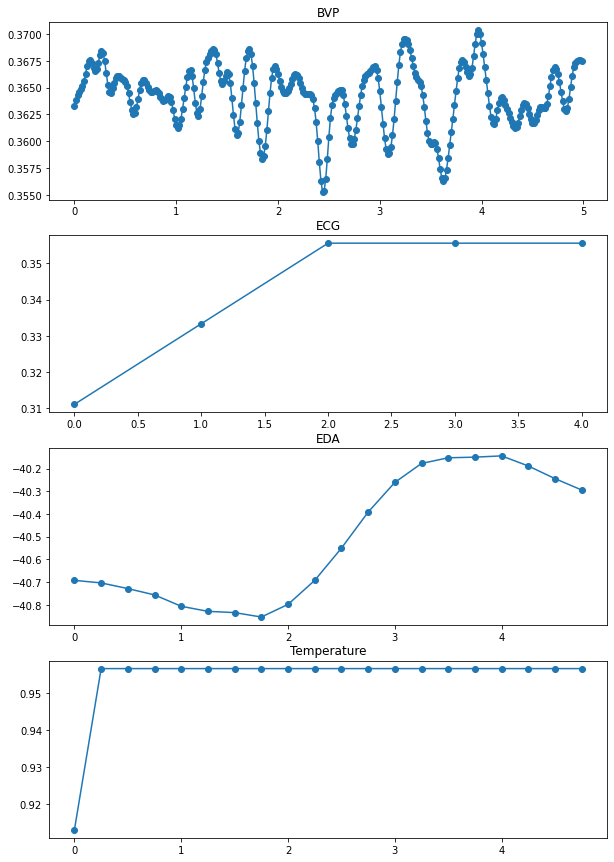

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

t_bvp = np.arange(0.,5.,1/bvp_sr)
t_ecg = np.arange(0t.,5.,1/ecg_sr)
t_eda = np.arange(0.,5.,1/eda_sr)
t_temp = np.arange(0.,5.,1/temp_sr)

plt.figure(figsize = (10,15))

plt.subplot(4, 1, 1)
plt.plot(t_bvp, sample['bvp'][0], 'o-')
plt.title('BVP')

plt.subplot(4, 1, 2)
plt.plot(t_ecg, sample['ecg'][0], 'o-')
plt.title('ECG')

plt.subplot(4, 1, 3)
plt.plot(t_eda, sample['eda'][0], 'o-')
plt.title('EDA')


plt.subplot(4, 1, 4)
plt.plot(t_temp, sample['temp'][0], 'o-')
plt.title('Temperature')

plt.show()

### Labels

In order to take a look at the distribution of labels, we first transformed them into ```DataFrame``` 

In [ ]:
import pandas as pd
subject_id = []
arousal = []
valence = []
for ID in dataset.keys(): # participant IDs 
    subject_id += [ID]*len(dataset[ID]['labels']['self_arousal'])
    arousal += dataset[ID]['labels']['self_arousal']
    valence += dataset[ID]['labels']['self_valence']

df_statistic=pd.DataFrame({"subject_id":subject_id, 'arousal':arousal, 'valence':valence})
df_statistic.head()

,subject_id,arousal,valence
0,p11,2,3
1,p11,2,3
2,p11,2,3
3,p11,2,3
4,p11,2,3


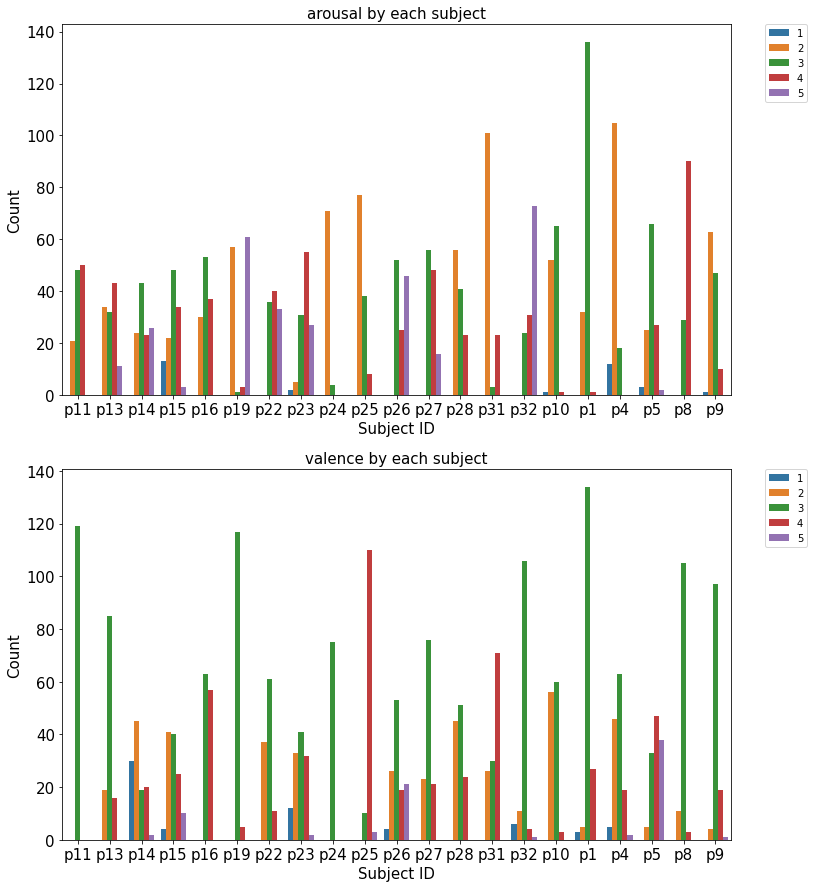

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (12, 15))
ax = fig.add_axes([0,0,1,1])
plt.subplot(2, 1, 1)

plt.tick_params(labelsize = 15)
sns.countplot(x = "subject_id", hue = "arousal", data = df_statistic)
plt.title("arousal by each subject", fontsize = 15)
plt.xlabel("Subject ID", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.subplot(2, 1, 2)
plt.tick_params(labelsize = 15)
sns.countplot(x = "subject_id", hue = "valence", data = df_statistic)
plt.title("valence by each subject", fontsize = 15)
plt.xlabel("Subject ID", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.legend(bbox_to_anchor=(1.05, 1), loc = 2, borderaxespad = 0.)
plt.show()


# Pre-processing

## Label Transformation

### Binary Label and One-hot Encoding

In the previous session, we could see that labels are concentrated on one side (especially 3). It's possible to perform multi-class classification (5 classes), but due to lack of data, this won't work well in practice (you may want to confirm this!).  Therefore, we decided to binarize the label by dividing the data into two sides (low vs. high) and perform one-hot encoding conversion so that we can learn it in Keras.

In [ ]:
from keras.utils import to_categorical

def low_high(x):
    if x>=3:
        return 1
    else:
        return 0

In [ ]:
from tf.keras.utils import to_categorical

for ID in dataset.keys():
    for label in dataset[ID]['labels'].keys():
        binary_label = pd.DataFrame(dataset[ID]['labels'][label]).applymap(low_high)    # (1) to binary
        one_hot_label = to_categorical(binary_label) # (2) to categorical // tf.keras.utils.to_categorical
        dataset[ID]['labels'][label] = one_hot_label

### Visualization after Transform

In [ ]:
subject_id = []
arousal = []
valence = []
for ID in dataset.keys():
    subject_id += [ID]*len(dataset[ID]['labels']['self_arousal'])
    arousal += [y[0] for y in dataset[ID]['labels']['self_arousal']]
    valence += [y[0] for y in dataset[ID]['labels']['self_valence']]
df_statistic = pd.DataFrame({"subject_id":subject_id, 'arousal':arousal, 'valence':valence})
df_statistic.head()

,subject_id,arousal,valence
0,p11,1.0,1.0
1,p11,1.0,1.0
2,p11,1.0,1.0
3,p11,1.0,1.0
4,p11,1.0,1.0


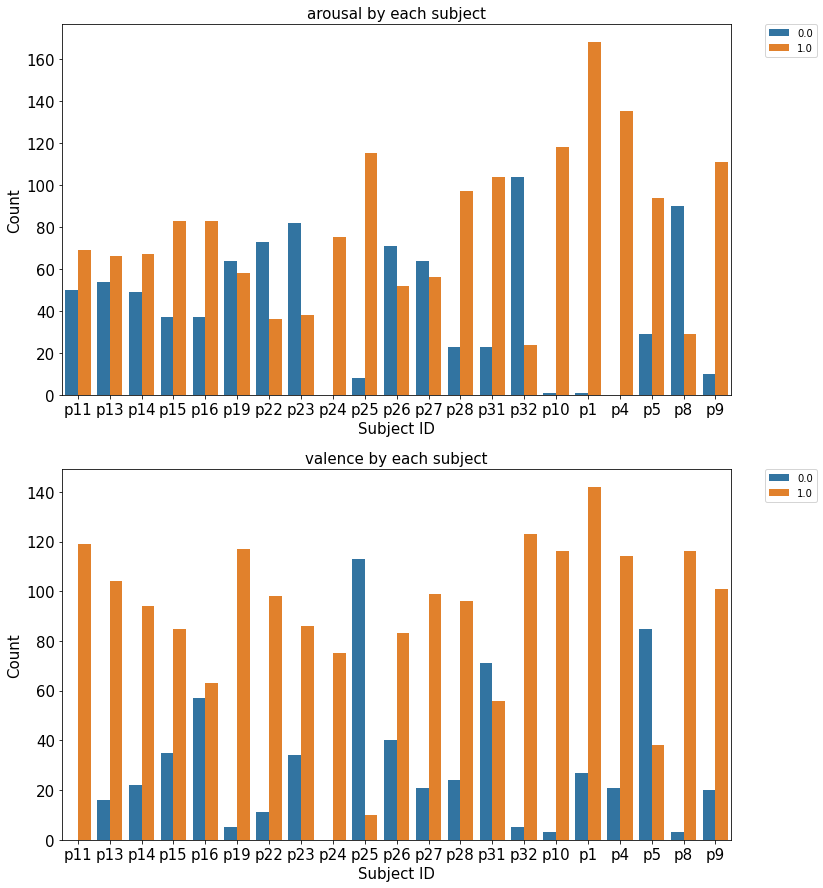

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (12, 15))
ax = fig.add_axes([0,0,1,1])
plt.subplot(2, 1, 1)

plt.tick_params(labelsize = 15)
sns.countplot(x = "subject_id", hue = "arousal", data = df_statistic)
plt.title("arousal by each subject", fontsize = 15)
plt.xlabel("Subject ID", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.subplot(2, 1, 2)
plt.tick_params(labelsize = 15)
sns.countplot(x = "subject_id", hue = "valence", data = df_statistic)
plt.title("valence by each subject", fontsize = 15)
plt.xlabel("Subject ID", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.legend(bbox_to_anchor=(1.05, 1), loc = 2, borderaxespad = 0.)
plt.show()


## Resampling

In the previous session, we found that each signal has different sampling rates. Too low sampling rates make it hard to build a robust model, and too high sampling rates cause too much time for learning. Thus, it is important to properly select sampling rates.

### Upsampling


Some interpolation methods are providen in scipy. The interp1d class in scipy.interpolate is a convenient method to create a function based on fixed data points, which can be evaluated anywhere within the domain defined by the given data using linear interpolation. An instance of this class is created by passing the 1-D vectors comprising the data. The instance of this class defines a '''__call__''' method and can therefore by treated like a function which interpolates between known data values to obtain unknown values (it also has a docstring for help). Behavior at the boundary can be specified at instantiation time. For the detailed information, please refer to the following: [HTML](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)

Another set of interpolations in interp1d is nearest, previous, and next, where they return the nearest, previous, or next point along the x-axis. Nearest and next can be thought of as a special case of a causal interpolating filter.

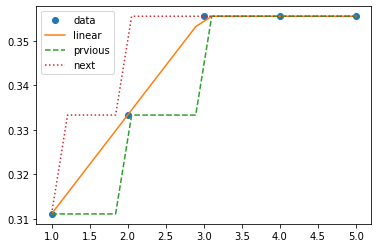

In [ ]:
from scipy.interpolate import interp1d
import numpy as np
# Sample data
ecg_1Hz = dataset['p1']['data']['ecg'][0]

# Orignal datapoint (1Hz * 5sec)
t = np.linspace(1, duration ,num = 5, endpoint=True)

# Interpolation
# interp1d(x, f(x), kind = interpolation method) 
# https://scipython.com/book/chapter-8-scipy/examples/scipyinterpolateinterp1d/
f1 = interp1d(t,ecg_1Hz, kind = 'linear')
f2 = interp1d(t,ecg_1Hz, kind = "previous")
f3 = interp1d(t,ecg_1Hz, kind = "next")


# upsampling 1Hz to 4Hz (4Hz * 5sec)
t_new = np.linspace(1, duration, num=20, endpoint=True)

plt.plot(t, ecg_1Hz, 'o')
plt.plot(t_new, f1(t_new), "-" )
plt.plot(t_new, f2(t_new),'--')
plt.plot(t_new, f3(t_new), ':')
plt.legend(['data','linear', 'prvious', 'next'])
plt.show()

We could confirm that the sample rate of the ECG was too low  (1 Hz). Therefore, up-sampling is performed (4Hz) using linear interpolation.


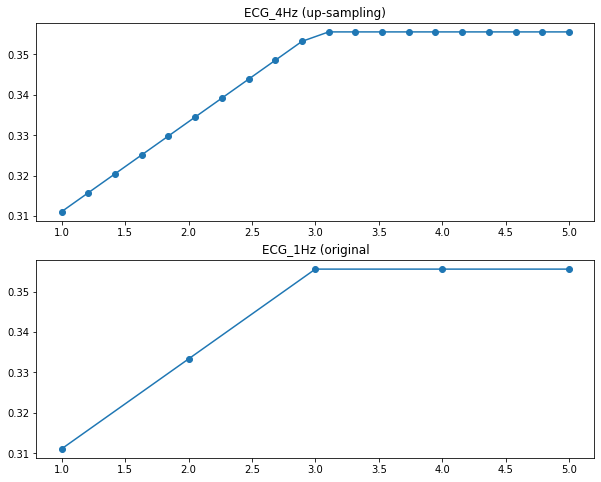

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

t_ecg_4Hz = np.linspace(1, duration ,num = 4*5, endpoint=True)
t_ecg_1Hz = np.linspace(1, duration ,num = 1*5, endpoint=True)

plt.figure(figsize = (10,8))

plt.subplot(2, 1, 1)
plt.plot(t_ecg_4Hz, f1(t_ecg_4Hz), 'o-')
plt.title('ECG_4Hz (up-sampling)')

plt.subplot(2, 1, 2)
plt.plot(t_ecg_1Hz, ecg_1Hz, 'o-')
plt.title('ECG_1Hz (original')

plt.show()

### Downsampling

In the previous session, we confirmed that sampling rate of  ```bvp``` was 64 Hz, which was far higher than that of the other sensors. We decided to downsample the rate of ```bvp``` to match with that of the other signals.
 

To carry out downsampling, we used ```rolling``` method provided by ```Pandas```. ```rolling``` method  provides a window or rolling sub-classed for the particular operation.




In [ ]:
bvp_64Hz = dataset['p1']['data']['bvp'][0]

df_bvp = pd.DataFrame(bvp_64Hz,columns = ['bvp_64Hz'])
# rolling(window size) 
# To down-sample from 64Hz to 4Hz, we performed windowing 64/4 data points using rolling method and calculate mean of them
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html
df_bvp = df_bvp.rolling(16).mean()   # (1) moving window mean
bvp_4Hz = df_bvp.iloc[list(range(15,320,16)),:] # (2) sub sampling
bvp_4Hz = np.array(bvp_4Hz)

In [ ]:
print("Length of samples before down-samplig: {} , Length of samples after down-sampling: {}".format(len(bvp_64Hz), len(bvp_4Hz)))

Length of samples before down-samplig: 320 , Length of samples after down-sampling: 20


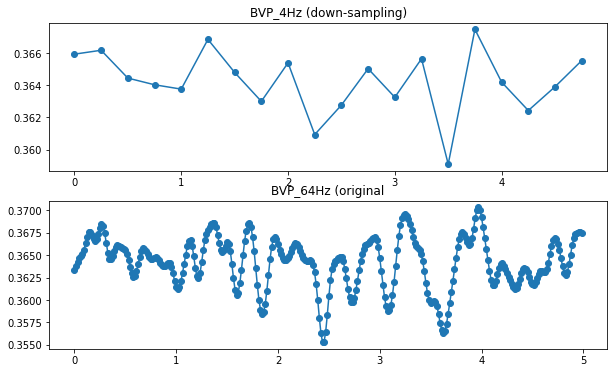

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

t_bvp_4Hz = np.arange(0.,5.,1/(bvp_sr//16))
t_bvp_64Hz = np.arange(0.,5.,1/bvp_sr)

plt.figure(figsize = (10,6))

plt.subplot(2, 1, 1)
plt.plot(t_bvp_4Hz, bvp_4Hz, 'o-')
plt.title('BVP_4Hz (down-sampling)')

plt.subplot(2, 1, 2)
plt.plot(t_bvp_64Hz, bvp_64Hz, 'o-')
plt.title('BVP_64Hz (original')

plt.show()

# Model Building 

## Metric

In [ ]:
# https://en.wikipedia.org/wiki/Precision_and_recall
# https://www.kaggle.com/code/kobiljon/precision-and-recall-relationship-f1-score

from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## LSTM: only using BVP data (sampled at 64 Hz)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers
from keras.layers.normalization import BatchNormalization

First, we converted data from a 1d array to a 2d array because if the length of the input is too long, gradient vanishing/exploding may occur.

In [ ]:
# Sample subject
X = dataset['p8']['data']['bvp']
X = X.reshape(-1,5,64)
Y = dataset['p8']['labels']['self_arousal']

In [ ]:
model = Sequential()
model.add(LSTM(128, return_sequences = True, dropout = 0.2, input_shape = (5,64)))
model.add(BatchNormalization()) # https://www.youtube.com/watch?v=sdXfAY_VD58
model.add(LSTM(128, dropout = 0.2))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5, 128)            98816     
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 128)            512       
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 231,682
Trainable params: 231,170
Non-trainable params: 512
_________________________________________________________________


## Parameters: How Many? And Why? 

In the above model summary, you may want to take a look at # parameters? 

lstm_16 (LSTM) (None, 5, 128) 98816

Here's the answer: 4 (#gates) * [nm + nn + n] where U: n\*m for input, and W: n\*n for pevious output. Thus, we have 4\*(64\*128 + 128\*128 + 128) = 98816. 

You may want to take a look at this article that illustrates the number of parameters in different neural networks: https://towardsdatascience.com/counting-no-of-parameters-in-deep-learning-models-by-hand-8f1716241889 

You can find some examples on LSTM in this article as well: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

<img src="https://www.researchgate.net/profile/Savvas-Varsamopoulos/publication/329362532/figure/fig5/AS:699592479870977@1543807253596/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell.jpg"/>
https://www.researchgate.net/figure/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell_fig5_329362532

# Training & Evaluation

## Sample training and testing

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 1)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy',f1_m])
hist = model.fit(X_train, y_train, batch_size = 8, epochs = 100, verbose = 1, validation_data = (X_val, y_val))

Epoch 1/100
9/9 [==============================] - 1s 85ms/step - loss: 1.0590 - accuracy: 0.6197 - f1_m: 0.6190 - val_loss: 0.6902 - val_accuracy: 0.6250 - val_f1_m: 0.6250
Epoch 2/100
9/9 [==============================] - 0s 9ms/step - loss: 0.7296 - accuracy: 0.7042 - f1_m: 0.7083 - val_loss: 0.6774 - val_accuracy: 0.6250 - val_f1_m: 0.6250
Epoch 3/100
9/9 [==============================] - 0s 9ms/step - loss: 0.9124 - accuracy: 0.5352 - f1_m: 0.5357 - val_loss: 0.6660 - val_accuracy: 0.6250 - val_f1_m: 0.6250
Epoch 4/100
9/9 [==============================] - 0s 9ms/step - loss: 1.0960 - accuracy: 0.5493 - f1_m: 0.5516 - val_loss: 0.6615 - val_accuracy: 0.6250 - val_f1_m: 0.6250
Epoch 5/100
9/9 [==============================] - 0s 8ms/step - loss: 0.8285 - accuracy: 0.5775 - f1_m: 0.5774 - val_loss: 0.6618 - val_accuracy: 0.6250 - val_f1_m: 0.6250
Epoch 6/100
9/9 [==============================] - 0s 8ms/step - loss: 0.7379 - accuracy: 0.5775 - f1_m: 0.5794 - val_loss: 0.6632 - v

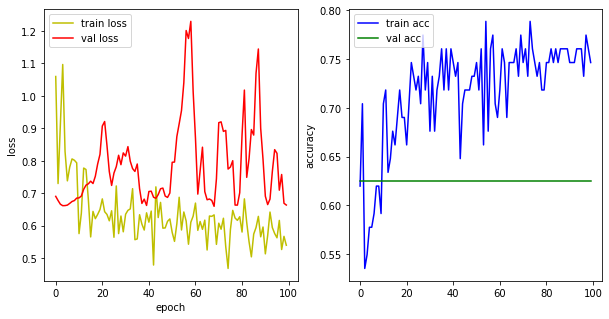

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,5))


loss_ax = plt.subplot(1,2,1)
loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label = 'val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc = 'upper left')

acc_ax = plt.subplot(1,2,2)
acc_ax.plot(hist.history['accuracy'], 'b', label = 'train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label = 'val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc ='upper left')

plt.show()


In [ ]:
_,acc,f1 = model.evaluate(X_test, y_test)
print("acc: {}%, f1:{}%.".format(round(acc*100,2),round(f1*100,2)))

1/1 [==============================] - 0s 2ms/step - loss: 0.5475 - accuracy: 0.8333 - f1_m: 0.8333
acc: 83.33%, f1:83.33%.


## Personalize Model Validation w/ 3-fold cross-validation 

We want to build a personalized model where we build a model per person (only using a specific person's data for model building). To evaluate a personalized model, we decided to use 3-fold cross-validation. But for this, we use stratification which ensures that each fold is a good representative of the whole (i.e., by considering class distribution). For this, we  use StratifiedKFold, a variation of KFold that considers class distribution for fold assignment. 

In [ ]:
from sklearn.model_selection import StratifiedKFold

y = [int(x[0]) for x in Y]
count = 0
acc_list, f1_list = [],[]
for train_index,test_index in StratifiedKFold(n_splits = 3).split(X,y):
    count += 1
    x_train,x_test=X[train_index],X[test_index]
    y_train,y_test=Y[train_index],Y[test_index]
  
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy',f1_m])
    hist = model.fit(x_train, y_train,epochs = 100 ,validation_data = (x_test, y_test))
    _,acc,f1 = model.evaluate(x_test,y_test)
    print("Result of {} fold: accuracy: {}, f1: {}".format(count,acc*100,f1*100))
    acc_list.append(acc*100)
    f1_list.append(f1*100)
print("Result")
print("acc: %.2f%% (+/- %.2f%%)" % (np.mean(acc_list), np.std(acc_list)))
print("f1: %.2f%% (+/- %.2f%%)" % (np.mean(f1_list), np.std(f1_list)))

Epoch 1/100
3/3 [==============================] - 1s 235ms/step - loss: 0.5718 - accuracy: 0.7722 - f1_m: 0.7771 - val_loss: 0.5776 - val_accuracy: 0.7500 - val_f1_m: 0.8438
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 0.6056 - accuracy: 0.7089 - f1_m: 0.7368 - val_loss: 0.5720 - val_accuracy: 0.7500 - val_f1_m: 0.8438
Epoch 3/100
3/3 [==============================] - 0s 11ms/step - loss: 0.6786 - accuracy: 0.7342 - f1_m: 0.7458 - val_loss: 0.5638 - val_accuracy: 0.7500 - val_f1_m: 0.8438
Epoch 4/100
3/3 [==============================] - 0s 11ms/step - loss: 0.5952 - accuracy: 0.7215 - f1_m: 0.7000 - val_loss: 0.5838 - val_accuracy: 0.7500 - val_f1_m: 0.8438
Epoch 5/100
3/3 [==============================] - 0s 11ms/step - loss: 0.5354 - accuracy: 0.7595 - f1_m: 0.7431 - val_loss: 0.5719 - val_accuracy: 0.7500 - val_f1_m: 0.8438
Epoch 6/100
3/3 [==============================] - 0s 11ms/step - loss: 0.5290 - accuracy: 0.7722 - f1_m: 0.7771 - val_loss: 0.56

## Leave-One-Subject-Out Cross Validation
We then build a population model. For fair evaluation, we intentially leave one user out for model building, and use that user for model validation. 

In [ ]:
# just reformatting the dataset object
res_dataset = {}
for ID in dataset.keys():
    res_dataset[ID] = {"data":dataset[ID]['data'], "labels":dataset[ID]['labels']}

In [ ]:
# !!note : make sure to go through skewness of each participant's dataset before doing LOSO

def make_LOSO_dataset(dataset, modal, label):
    LOSO_dataset = {}
    for ID in dataset.keys():
        count=0
        for ID2 in dataset.keys():
            if ID == ID2:
                test_X = dataset[ID]['data'][modal].reshape(-1,5,64)
                test_Y = dataset[ID]['labels'][label]
            elif ID != ID2:
                X = dataset[ID2]['data'][modal].reshape(-1,5,64)
                Y = dataset[ID2]['labels'][label]
                if count == 0:
                    train_X = X
                    train_Y = Y
                    count+=1
                else:
                    train_X = np.concatenate((train_X,X), axis=0)
                    train_Y = np.concatenate((train_Y,Y), axis=0)
     
        LOSO_dataset[ID] = {"train": {"X": train_X, "Y": train_Y}, 'test': {"X":test_X, 'Y':test_Y}}
    return LOSO_dataset

In [ ]:
LOSO_dataset=make_LOSO_dataset(res_dataset, 'bvp', 'self_arousal')

This figure shows an example of LOSO model. Since we have 21 users, we have a total of 21 configurations. 

![Fold2](https://drive.google.com/uc?id=1_jrm1OGncCJa-9U_vFxZYxU3mUGbESLY)

In [ ]:
# This is a very time consuming block because you are training for all participants.

acc_list, f1_list = [],[]
for ID in LOSO_dataset.keys():
    print("test ID: " + ID)
    x_train,x_test = LOSO_dataset[ID]['train']['X'],LOSO_dataset[ID]['test']['X']
    y_train,y_test = LOSO_dataset[ID]['train']['Y'],LOSO_dataset[ID]['test']['Y']
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy',f1_m])
    hist=model.fit(x_train, y_train,epochs = 100 ,validation_data = (x_test, y_test))
    _,acc,f1 = model.evaluate(x_test,y_test)
    print("Result of {} : accuracy: {}, f1: {}".format(ID,acc*100,f1*100))
    acc_list.append(acc*100)
    f1_list.append(f1*100)
print("Result")
print("acc: %.2f%% (+/- %.2f%%)" % (np.mean(acc_list), np.std(acc_list)))
print("f1: %.2f%% (+/- %.2f%%)" % (np.mean(f1_list), np.std(f1_list)))

test ID: p11
Epoch 1/100
70/70 [==============================] - 1s 17ms/step - loss: 0.7239 - accuracy: 0.5579 - f1_m: 0.5586 - val_loss: 1.0344 - val_accuracy: 0.5798 - val_f1_m: 0.6002
Epoch 2/100
70/70 [==============================] - 0s 7ms/step - loss: 0.6271 - accuracy: 0.6413 - f1_m: 0.6404 - val_loss: 0.7750 - val_accuracy: 0.5798 - val_f1_m: 0.6002
Epoch 3/100
70/70 [==============================] - 0s 7ms/step - loss: 0.6129 - accuracy: 0.6530 - f1_m: 0.6537 - val_loss: 0.7130 - val_accuracy: 0.5798 - val_f1_m: 0.6002
Epoch 4/100
70/70 [==============================] - 0s 7ms/step - loss: 0.6116 - accuracy: 0.6580 - f1_m: 0.6578 - val_loss: 0.9088 - val_accuracy: 0.5798 - val_f1_m: 0.6002
Epoch 5/100
70/70 [==============================] - 0s 7ms/step - loss: 0.6079 - accuracy: 0.6503 - f1_m: 0.6502 - val_loss: 0.7126 - val_accuracy: 0.5798 - val_f1_m: 0.6002
Epoch 6/100
70/70 [==============================] - 0s 7ms/step - loss: 0.6125 - accuracy: 0.6566 - f1_m: 0.65

KeyboardInterrupt: ignored

# Homework

## Q1 Build a multi-modal model (1.5 pt)

We learned how to sample signals and make model in the last session. Do the following tasks.

(1) Downsample ```Participant8 (P8)```'s BVP 64Hz) signal to ```4Hz``` and merge it with temperature data (```4Hz```). This can be considered as "early fusion." 

(2) Reshape to (20, 2) This means that there are two channels where each channel has 20 samples (5 seconds * 4 Hz = 20 samples). It considers 20 samples in a single LSTM layer (and each input is two dimensional). 

(3) Create a two-layer LSTM model where each LSTM layer has 64 hidden units

(4) Train your model

(5) Save the model to your path 

(6) Reason why you have specific numbers of model parameters at each layer 


In [ ]:
# save your model
path = '/content/drive/My Drive/Sensor Data Science/model/'  # your path 'path' 
model.save(path+'model.h5')

### (1) Downsample Participant8 (P8)'s BVP 64Hz signal to 4Hz and merge it with temperature data (4Hz). This can be considered as "early fusion."

In [9]:
import pandas as pd
import numpy as np

bvp_64Hz = pd.read_csv('/content/drive/My Drive/EE5104 Datasets/Lab 12 data/e4_data/8/E4_BVP.csv')
Temp_data = pd.read_csv('/content/drive/My Drive/EE5104 Datasets/Lab 12 data/e4_data/8/E4_TEMP.csv')
print(bvp_64Hz.head(), 'length: ', len(bvp_64Hz))
print(Temp_data.head(), 'length: ', len(Temp_data))

      timestamp  pid  value device_serial  device_number     entry_time
0  1.548224e+12    8    0.0        A01A3A              5  1548223953000
1  1.548224e+12    8    0.0        A01A3A              5  1548223953000
2  1.548224e+12    8    0.0        A01A3A              5  1548223953000
3  1.548224e+12    8    0.0        A01A3A              5  1548223953000
4  1.548224e+12    8    0.0        A01A3A              5  1548223953000 length:  81857
      timestamp  pid  value device_serial  device_number     entry_time
0  1.548224e+12    8  30.99        A01A3A              5  1548223953000
1  1.548224e+12    8  30.99        A01A3A              5  1548223953000
2  1.548224e+12    8  30.99        A01A3A              5  1548223953000
3  1.548224e+12    8  30.99        A01A3A              5  1548223953000
4  1.548224e+12    8  30.99        A01A3A              5  1548223953000 length:  5117


In [10]:
df_bvp = pd.DataFrame(bvp_64Hz,columns = ['value'])
df_bvp = df_bvp.rolling(16).mean()   # (1) moving window mean
bvp_4Hz = df_bvp.iloc[list(range(15,81857,16)),:] # (2) sub sampling
bvp_4Hz = np.array(bvp_4Hz)
print("Length of samples before down-samplig: {} , Length of samples after down-sampling: {}".format(len(bvp_64Hz), len(bvp_4Hz)))

Length of samples before down-samplig: 81857 , Length of samples after down-sampling: 5116


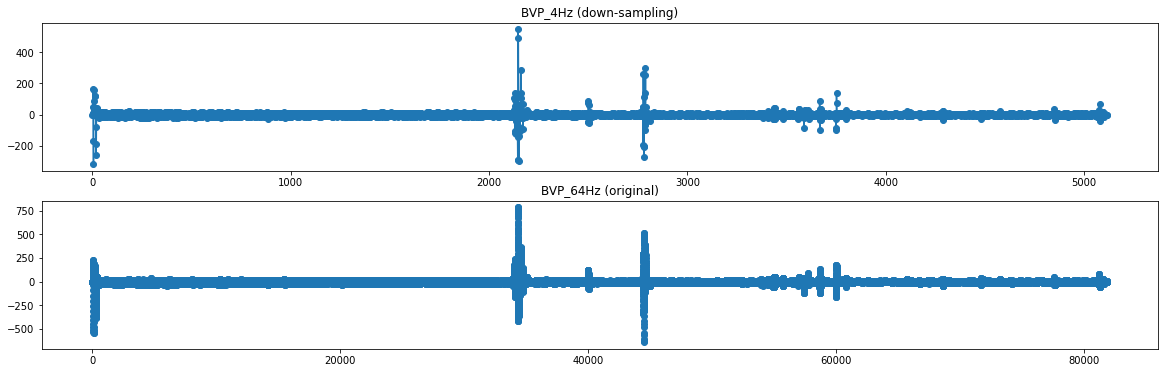

In [11]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize = (20,6))

plt.subplot(2, 1, 1)
plt.plot(bvp_4Hz, 'o-')
plt.title('BVP_4Hz (down-sampling)')

plt.subplot(2, 1, 2)
plt.plot(bvp_64Hz['value'], 'o-')
plt.title('BVP_64Hz (original)')

plt.show()

In [12]:
# print(Temp_data['value'][:5116])
bvp_4Hz_data = pd.DataFrame(bvp_4Hz)
# print(bvp_4Hz_data)

Merge_data = pd.concat([Temp_data['value'][:5116], bvp_4Hz_data], axis=1)
Merge_data.columns = ['Temperature', 'BVP_4Hz']
Merge_data

,Temperature,BVP_4Hz
0,30.99,-0.003750
1,30.99,2.164375
2,30.99,11.654375
3,30.99,49.225000
4,30.99,160.436250
...,...,...
5111,30.19,-1.565625
5112,30.21,-3.251250
5113,30.21,0.054375
5114,30.21,-5.090000


### (2) Reshape to (20, 2) This means that there are two channels where each channel has 20 samples (5 seconds * 4 Hz = 20 samples). It considers 20 samples in a single LSTM layer (and each input is two dimensional).

In [14]:
X = np.array(Merge_data[:2000]).reshape(-1, 2, 20)
# print(X)

### (3) Create a two-layer LSTM model where each LSTM layer has 64 hidden units

In [15]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization

model = Sequential()
model.add(LSTM(64, return_sequences = True, dropout = 0.2, input_shape = (2,20)))
model.add(BatchNormalization()) # https://www.youtube.com/watch?v=sdXfAY_VD58
model.add(LSTM(64, dropout = 0.2))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 64)             21760     
                                                                 
 batch_normalization (BatchN  (None, 2, 64)            256       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 55,361
Trainable params: 55,105
Non-traina

### (4) Train your model

In [16]:
annotation = pd.read_csv('/content/drive/My Drive/EE5104 Datasets/Lab 12 data/emotion_annotations/self_annotations/P8.self.csv')
print(len(annotation))
annotation

120


,seconds,arousal,valence,cheerful,happy,angry,nervous,sad,boredom,confusion,...,surprise,none_1,confrustion,contempt,dejection,disgust,eureka,pride,sorrow,none_2
0,5,4,3,4,3,1,2,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x
1,10,4,3,4,3,1,2,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x
2,15,4,3,4,3,1,2,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x
3,20,4,3,4,3,1,2,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x
4,25,4,3,4,3,1,2,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,580,4,3,3,3,1,2,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x
116,585,4,3,3,3,1,2,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x
117,590,4,3,3,3,1,2,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x
118,595,4,3,3,3,1,2,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x


In [17]:
from sklearn.model_selection import train_test_split
Y = annotation.arousal[:100]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 1)

In [18]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy',f1_m])
hist = model.fit(X_train, y_train, batch_size = 8, epochs = 100, verbose = 1, validation_data = (X_val, y_val))

Epoch 1/100
8/8 [==============================] - 10s 130ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_m: 1.1001 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_f1_m: 1.0698
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_m: 1.1733 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_f1_m: 1.0000
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_m: 1.1611 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_f1_m: 1.0000
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_m: 1.2361 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_f1_m: 1.0000
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_m: 1.0927 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_f1_m: 1.0000
Epoch 6/100
8/8 [==============================]

### (5) Save the model to your path

In [20]:
# save your model
path = '/content/drive/My Drive/Sensor Data Science/model/'  # your path 'path' 
model.save(path+'model.h5')

### (6) Reason why you have specific numbers of model parameters at each layer



In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 64)             21760     
                                                                 
 batch_normalization (BatchN  (None, 2, 64)            256       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 55,361
Trainable params: 55,105
Non-traina

params = dim(W)+dim(V)+dim(U) = n*n + kn + nm
```
# n - dimension of hidden layer
# k - dimension of output layer
# m - dimension of input layer
```



## Q2 Apply transfer learning (1.5 pt)
Transfer learning is a machine learning method where a model developed for one task is reused as the starting point for training another model for a different task.

It's also known as pre-training and fine-tuning in that pre-trained models are used as a starting point for fine-tuning it using a small number of datasets. This technique is quite popular among computer vision and natural language processing tasks. 

In the following, we examine an example of transfer learning. We just provided a code segment to better guide you to use transfer learning. You've already read the reading assignment, and for the detailed implementation issues, please refer to [the Keras web page](https://keras.io/guides/transfer_learning/). 

In [ ]:
# load pretrained model
model_A = keras.models.load_model("my_model_A.h5")

# load weight except the last layer (classifer)
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])

# Add last layer
model_B_on_A.add(keras.layers.Dense(2, activation="sigmoid"))

# Freeze all layers exept the last layer
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

# confile and training
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))


do the following tasks:

(1) Load the P8's model designed in Q1. 

(2) Reuse P8's LSTM weights to retrain a classifier only using P9's dataset. We call this model as  ```model 1```. 

(3) Train the whole model (LSTM+Classifier) using P9's dataset. We call this model as ```model 2```

(5) Compare the performance of ```model 1``` and ```model 2``` and explain your answer.

(6) (Extra Point: 1 pt) Another useful way of transfer learning is personalization of a global model. For example, in our example, you can leave P8's data for training (just like a LOSO evaluation). And then you can use that model to perform transfer learning using P8's data. If you do this, we'll give you an extra 1 point. 


In [27]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Load model
path = '/content/drive/My Drive/Sensor Data Science/model/'  # your path 'path' 
model_q1 = keras.models.load_model(path+'model.h5', custom_objects={"f1_m": f1_m })

bvp9 = pd.read_csv('/content/drive/My Drive/EE5104 Datasets/Lab 12 data/e4_data/9/E4_BVP.csv')
Temp9 = pd.read_csv('/content/drive/My Drive/EE5104 Datasets/Lab 12 data/e4_data/9/E4_TEMP.csv')
annotation = pd.read_csv('/content/drive/My Drive/EE5104 Datasets/Lab 12 data/emotion_annotations/self_annotations/P9.self.csv')
df_bvp = pd.DataFrame(bvp_64Hz,columns = ['value'])
df_bvp = df_bvp.rolling(16).mean()  
bvp_4Hz = df_bvp.iloc[list(range(15,81857,16)),:] 

Merge_data = pd.concat([Temp9['value'][:5116], bvp_4Hz_data], axis=1)
Merge_data.columns = ['Temperature', 'BVP_4Hz']

X = np.array(Merge_data[:2000]).reshape(-1, 2, 20)
Y = annotation.arousal[:100]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 1)
# Freeze bottom layer
model1 = keras.models.Sequential(model_q1.layers[:-1])
model1.add(keras.layers.Dense(1, activation="sigmoid"))
for layer in model1.layers[:-1]:
    layer.trainable = False

# Train Top layer
model1.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

history1 = model1.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


2/2 [==============================] - 4s 1s/step - loss: 0.3397 - accuracy: 0.0000e+00 - val_loss: -0.2393 - val_accuracy: 0.0000e+00
Epoch 2/50
2/2 [==============================] - 0s 42ms/step - loss: 0.2623 - accuracy: 0.0000e+00 - val_loss: -0.7280 - val_accuracy: 0.0000e+00
Epoch 3/50
2/2 [==============================] - 0s 38ms/step - loss: -0.2018 - accuracy: 0.0000e+00 - val_loss: -1.1471 - val_accuracy: 0.0000e+00
Epoch 4/50
2/2 [==============================] - 0s 40ms/step - loss: -1.1777 - accuracy: 0.0000e+00 - val_loss: -1.6267 - val_accuracy: 0.0000e+00
Epoch 5/50
2/2 [==============================] - 0s 25ms/step - loss: -0.8919 - accuracy: 0.0000e+00 - val_loss: -1.9894 - val_accuracy: 0.0000e+00
Epoch 6/50
2/2 [==============================] - 0s 25ms/step - loss: -1.2797 - accuracy: 0.0000e+00 - val_loss: -2.3408 - val_accuracy: 0.0000e+00
Epoch 7/50
2/2 [==============================] - 0s 24ms/step - loss: -1.1195 - accuracy: 0.0000e+00 - val_loss: -2.6546

In [28]:
# make model 2
model2 = keras.models.Sequential(model_q1.layers[:])
model2.compile(loss="binary_crossentropy",
               optimizer=keras.optimizers.SGD(lr=1e-3),
               metrics=["accuracy"])
history2 = model2.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
#your answer in a textbox 

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


2/2 [==============================] - 7s 813ms/step - loss: -116.0640 - accuracy: 0.0000e+00 - val_loss: -151.2609 - val_accuracy: 0.0000e+00
Epoch 2/50
2/2 [==============================] - 0s 26ms/step - loss: -128.1643 - accuracy: 0.0000e+00 - val_loss: -151.5993 - val_accuracy: 0.0000e+00
Epoch 3/50
2/2 [==============================] - 0s 27ms/step - loss: -102.3388 - accuracy: 0.0000e+00 - val_loss: -151.8729 - val_accuracy: 0.0000e+00
Epoch 4/50
2/2 [==============================] - 0s 27ms/step - loss: -66.3613 - accuracy: 0.0000e+00 - val_loss: -152.0504 - val_accuracy: 0.0000e+00
Epoch 5/50
2/2 [==============================] - 0s 26ms/step - loss: -134.3720 - accuracy: 0.0000e+00 - val_loss: -152.4056 - val_accuracy: 0.0000e+00
Epoch 6/50
2/2 [==============================] - 0s 26ms/step - loss: -80.3393 - accuracy: 0.0000e+00 - val_loss: -152.6207 - val_accuracy: 0.0000e+00
Epoch 7/50
2/2 [==============================] - 0s 24ms/step - loss: -101.8625 - accuracy: 0

- Loss of model 1 is much less than model 2.
- Model 1 's perfomance is better. 
